In [1]:
import numpy as np 
import pandas as pd

train_file = np.load("../data/train.npz")
data = train_file['data']
print("train_data's shape", data.shape)

test_file = np.load("../data/test_input.npz")
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


The training set should be of shape (10000, 50, 110, 6). There are 10,000 training scenes, each scene contains 50 agents' trajectories over 110 time steps, and each time step has 6 dimensions.

Columns
The 6 dimensions are, respectively:

position_x: x-coordinate of the agent's position <br>
position_y: y-coordinate of the agent's position <br>
velocity_x: x-component of the agent's velocity <br>
velocity_y: y-component of the agent's velocity <br>
heading: heading angle of the agent in radians <br>
object_type: encoded object type. The integers indexes this array: <br>
['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown'] <br>

For many of the agents, their trajectory is not complete. In the case that this happens or when there are less than 50 agents in the scene, we pad the matrix with zeros. (so don't be surprised when you see a lot of zeros!) <br>

Your task is to predict the ego vehicle (agent index 0)'s trajectory. We will pre in a scene given the first 50 time steps (5 seconds) to predict the next 60 time steps. <br>
This means that the test set input has shape (2100, 50, 50, 6) (2100 scenes, 50 agents, 50 time steps input, 6 dimensions), and you are expected to upload a csv file of shape (2100 * 60, 2) (2100 scenes, 1 ego agent, 60 time steps prediction, 2 dimensions - just x and y). 

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

train_data, val_data = train_test_split(data, test_size=0.20, random_state=42)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32, device=device),
            origin=torch.tensor(origin, dtype=torch.float32, device=device).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32, device=device),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

# N = len(train_data)
# val_size = int(0.1 * N)
# train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(val_data, scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

In [24]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, x):
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [37]:
model = MLP(50 * 50 * 6, 60 * 2).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers

early_stopping_patience = 10

def get_val_loss(model, val_dataloader):
    
    model.eval()

    total_val_loss = 0
    total_val_mse = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            batch_X = batch.x
            
            pred = model(batch_X)
           
            y = batch.y.view(batch.num_graphs, 60, 2)
            #print(pred.shape)
            total_val_loss += criterion(pred, y).item()

            # show MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            total_val_mse += nn.MSELoss()(pred, y).item()
            
    val_loss = total_val_loss / len(val_dataloader)
    val_mse = total_val_mse / len(val_dataloader)
            
    print(f'Validation Loss: {val_loss:.4f} Validation MSE: {val_mse:.4f}')
    return val_loss, val_mse
    
def train_model(model, train_loader, val_loader, batch_size=64, epochs=10):

    train_loss = []
    val_loss = []
    val_mse = []

    best_val_loss = float('inf')
    no_improvement = 0
    
    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        
        for batch in tqdm.tqdm(train_loader):

            batch = batch.to(device)

            batch_X = batch.x
            batch_y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            
            # Calculate loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print epoch statistics
        train_loss.append(running_loss/len(train_loader))
        print(f'Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}')
        
        v_loss, v_mse = get_val_loss(model, val_loader)
        val_loss.append(v_loss)
        val_mse.append(v_mse)

        scheduler.step()
       
        if v_loss < best_val_loss - 1e-3:
            best_val_loss = v_loss
            no_improvement = 0
            torch.save(model.state_dict(), "mlp_model.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break
                
    print("Best val loss", best_val_loss)
    return train_loss, val_loss, val_mse

train_loss, val_loss, val_mse = train_model(model, train_dataloader, val_dataloader, epochs=40)

100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 44.27it/s]


Epoch 1, Train Loss: 38.9363
Validation Loss: 6.1824 Validation MSE: 302.9376


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.98it/s]


Epoch 2, Train Loss: 6.2756
Validation Loss: 6.1822 Validation MSE: 302.9261


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 49.19it/s]


Epoch 3, Train Loss: 6.2749
Validation Loss: 6.1813 Validation MSE: 302.8853


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.69it/s]


Epoch 4, Train Loss: 6.2755
Validation Loss: 6.1814 Validation MSE: 302.8901


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.47it/s]


Epoch 5, Train Loss: 6.2750
Validation Loss: 6.1817 Validation MSE: 302.9012


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 48.31it/s]


Epoch 6, Train Loss: 6.2745
Validation Loss: 6.1812 Validation MSE: 302.8779


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.26it/s]


Epoch 7, Train Loss: 6.2746
Validation Loss: 6.1818 Validation MSE: 302.9088


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.34it/s]


Epoch 8, Train Loss: 6.2754
Validation Loss: 6.1819 Validation MSE: 302.9125


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.76it/s]


Epoch 9, Train Loss: 6.2746
Validation Loss: 6.1813 Validation MSE: 302.8813


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 48.77it/s]


Epoch 10, Train Loss: 6.2739
Validation Loss: 6.1805 Validation MSE: 302.8463


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.23it/s]


Epoch 11, Train Loss: 6.2746
Validation Loss: 6.1801 Validation MSE: 302.8240


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.78it/s]


Epoch 12, Train Loss: 6.2745
Validation Loss: 6.1799 Validation MSE: 302.8174


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 48.48it/s]


Epoch 13, Train Loss: 6.2746
Validation Loss: 6.1800 Validation MSE: 302.8224


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.41it/s]


Epoch 14, Train Loss: 6.2744
Validation Loss: 6.1798 Validation MSE: 302.8124


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.82it/s]


Epoch 15, Train Loss: 6.2745
Validation Loss: 6.1798 Validation MSE: 302.8118


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.12it/s]


Epoch 16, Train Loss: 6.2745
Validation Loss: 6.1805 Validation MSE: 302.8454


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 46.96it/s]


Epoch 17, Train Loss: 6.2745
Validation Loss: 6.1801 Validation MSE: 302.8270


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 45.72it/s]


Epoch 18, Train Loss: 6.2742
Validation Loss: 6.1796 Validation MSE: 302.7992


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 45.46it/s]


Epoch 19, Train Loss: 6.2934
Validation Loss: 6.1807 Validation MSE: 302.8541


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 45.68it/s]


Epoch 20, Train Loss: 6.2751
Validation Loss: 6.1810 Validation MSE: 302.8702


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 44.88it/s]


Epoch 21, Train Loss: 6.2750
Validation Loss: 6.1813 Validation MSE: 302.8857
Early stop!
Best val loss 6.180080580332922


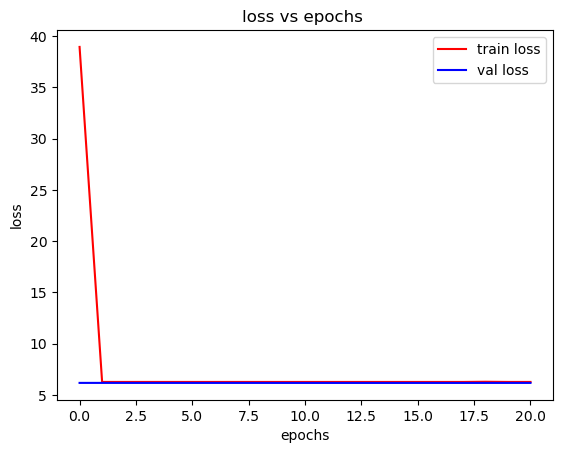

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
#plt.plot(val_mse, 'g', label='val mse')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs ')
plt.legend()
plt.savefig('mlp_loss_vs_epochs.png')

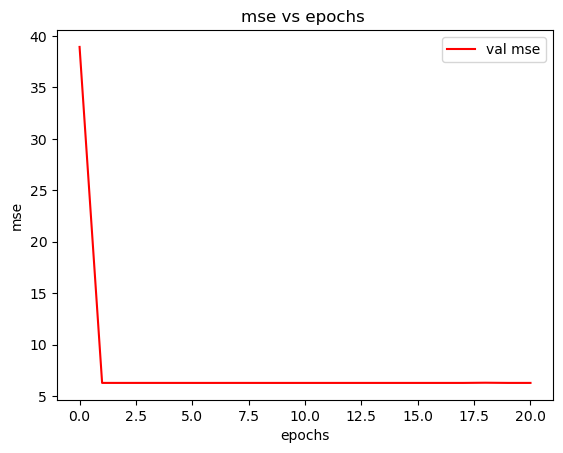

In [39]:
plt.plot(train_loss, 'r', label='val mse')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('mse vs epochs ')
plt.legend()
plt.savefig('mlp_val_mse_vs_epochs.png')

In [40]:
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

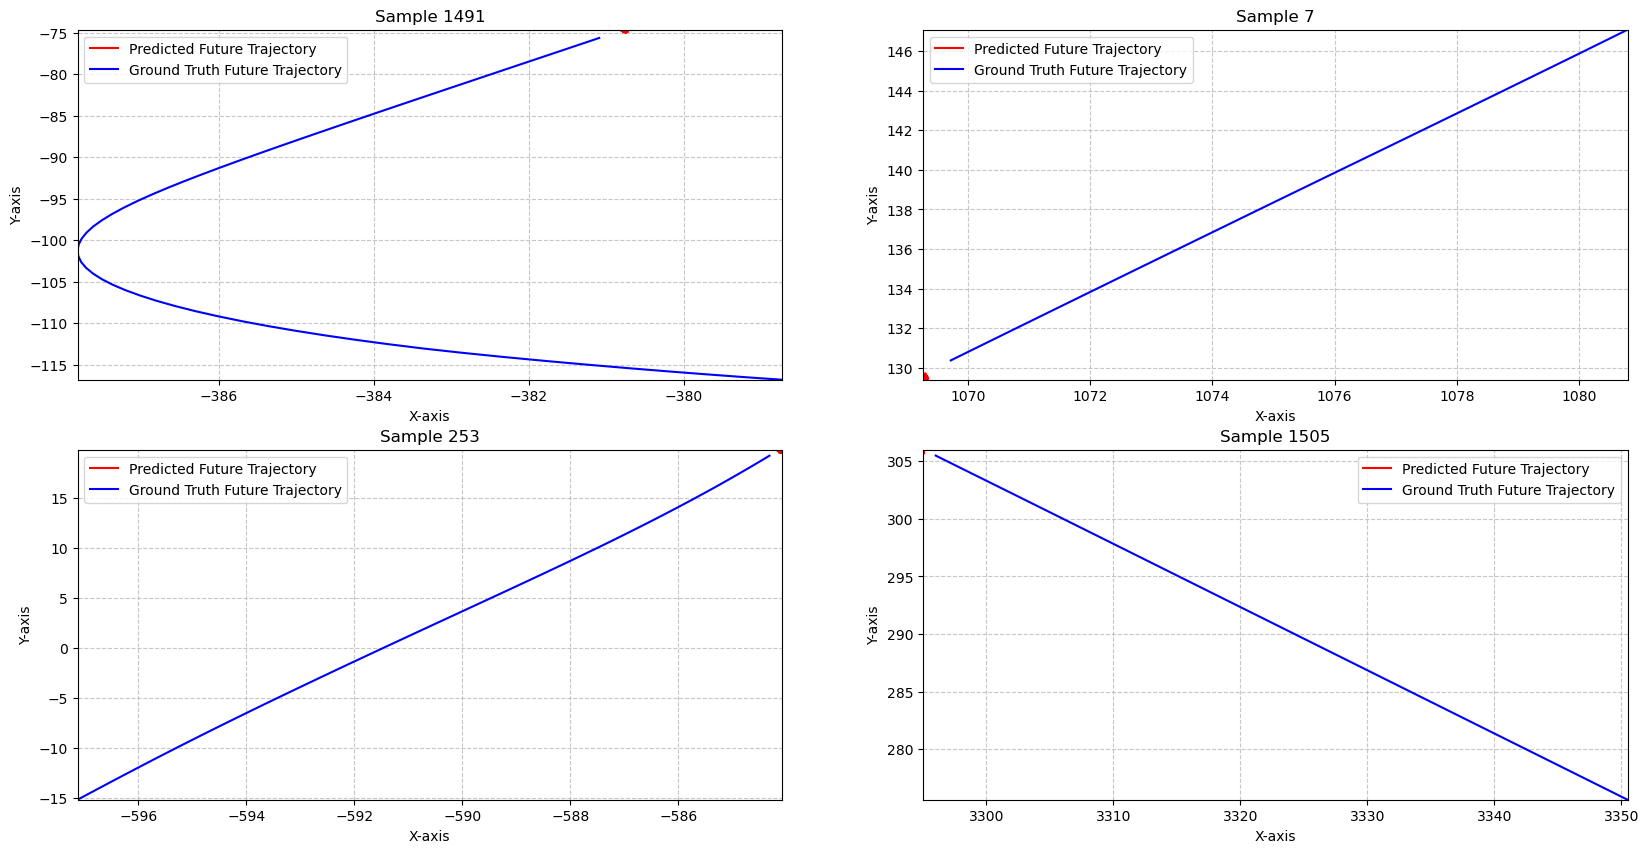

In [ ]:
model.load_state_dict(torch.load("mlp_model.pt"))

model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)

    pred = model(batch.x)
    
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)
    
    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.savefig('mlp_pred_true_trajectories.png')
plt.show()

In [46]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

model.load_state_dict(torch.load("mlp_model.pt"))

model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        pred_norm = model(batch.x)

        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('mlp_submission.csv', index=True)